In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
from tqdm.notebook import tqdm
import matplotlib.pylab as pylab

from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

This notebook does a line-of-sight integral to build spatial templates given a density distribution.

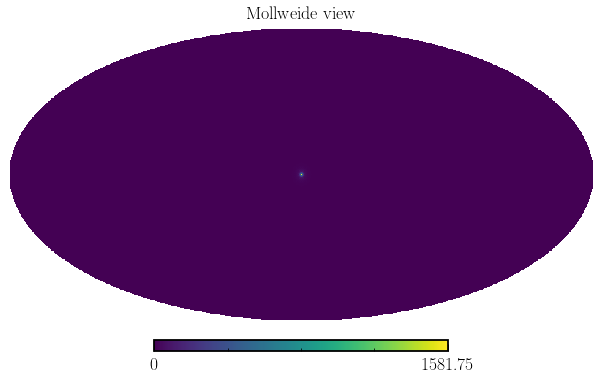

In [170]:
from utils.templates import get_NFW2_template

hp.mollview(get_NFW2_template(gamma=1.5))

## 1. Preamble/functions

In [3]:
def mod(dividends, divisor):
    """ Return dividends (array) mod divisor (double)
        Stolen from Nick's code
    """

    output = np.zeros(len(dividends))

    for i in range(len(dividends)): 
        output[i] = dividends[i]
        done=False
        while (not done):
            if output[i] >= divisor:
                output[i] -= divisor
            elif output[i] < 0.:
                output[i] += divisor
            else:
                done=True

    return output

In [74]:
nside = 128
npix = hp.nside2npix(nside)
rsun = 8.34  # Distance between Sun and GC in kpc

In [126]:
import sys
sys.path.append("../")
from utils import create_mask as cm

mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 50)
mask_restrict = np.where(mask == 0)[0]

In [115]:
# Get lon/lat array

theta_ary, phi_ary = hp.pix2ang(nside, mask_restrict)

b_ary = np.pi / 2. - theta_ary
l_ary = mod(phi_ary + np.pi, 2. * np.pi) - np.pi

In [143]:
# Functions for density and distance to GC

def rho_NFW(r, gamma=1.):
    """ Subhalo number density from Aquarius (cf. CLUMPY paper) 
    """
    r_s = 20.0
    return (r / r_s) ** -gamma * (1 + (r / r_s)) ** (-3 + gamma) 

def rGC(s_ary, b_ary, l_ary):
    """ Distance to GC as a function of LOS distance, latitude, longitude
    """
    return np.sqrt(s_ary ** 2 - 2. * rsun * np.transpose(np.multiply.outer(s_ary, np.cos(b_ary) * np.cos(l_ary))) + rsun ** 2)

## 2. Do LOS integral

In [160]:
s_ary = np.linspace(0, 50, 100)

In [161]:
# LOS integral of density^2
int_rho2_temp = np.trapz(rho_NFW(rGC(s_ary, b_ary, l_ary), gamma=1.2) ** 2, s_ary, axis=1)

In [162]:
int_rho2 = np.zeros(hp.nside2npix(128))
int_rho2[~mask] = int_rho2_temp

# Normalize
int_rho2 /= np.mean(int_rho2)

## 3. Plot and save

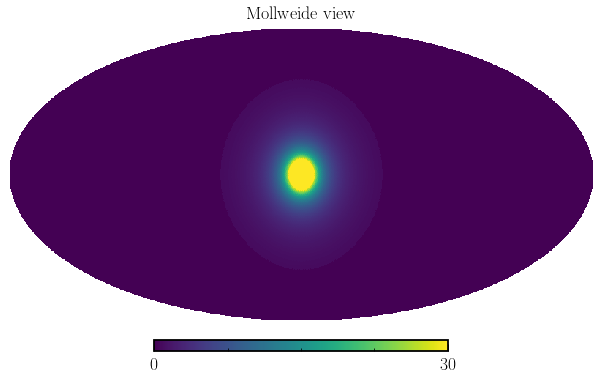

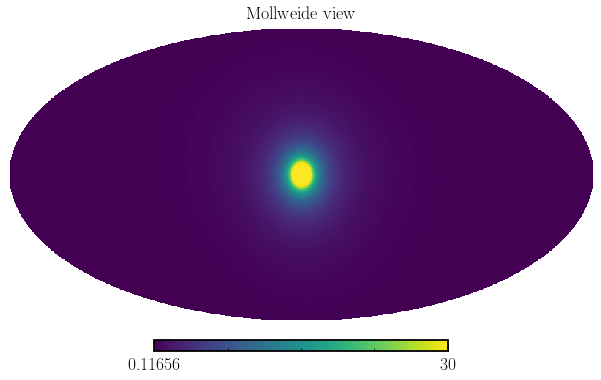

In [164]:
temp_gce = np.load("../data/fermi_data/template_gce.npy")
temp_gce /= np.mean(temp_gce)
hp.mollview(int_rho2, max=30)
hp.mollview(temp_gce, max=30)

In [40]:
# Save density map
np.save("../data/eaq_density_temp.npy", int_rho)
np.save("../data/eaq_density2_temp.npy", int_rho2)